In [87]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from tqdm import tqdm

In [88]:
dataset = ImageFolder('/kaggle/input/tiny-imagenet/tiny-imagenet-200/train')

In [89]:
nb_shots = 5
nb_ways = 3

# Get class names
class_names = dataset.classes

# Select 3 classes which were not in the training classes of the TinyNet40
selected_classes = class_names[50:50+nb_ways]
print(selected_classes)

['n02410509', 'n02415577', 'n02423022']


In [90]:
import random


def support(nb_shots, dataset, selected_classes):
    support_set = []
    selected_indices = []
        
    for class_name in selected_classes:

        # Get indices of images belonging to the current class
        class_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_names.index(class_name)]

        # Select 5 random images for the support set
        selected_indices = random.sample(class_indices, nb_shots)

        # Append (image, class) tuples to the support set
        support_set.extend([(dataset[index][0], class_name) for index in selected_indices])
        
    return support_set, selected_indices

support_set, selected_indices = support(nb_shots, dataset, selected_classes)

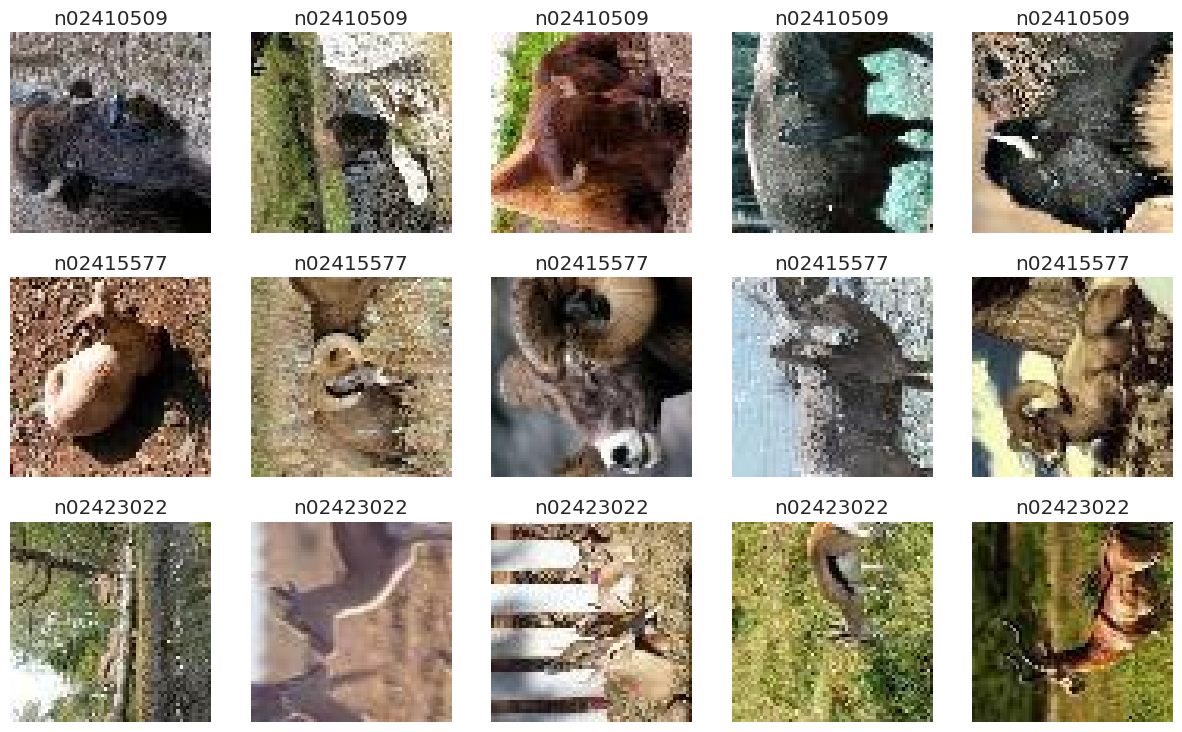

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(shots, ways, dataset):
    fig, axes = plt.subplots(ways, shots, figsize=(15, 9))

    for i in range(ways):
        for j in range(shots):
            image, class_name = dataset[i * shots + j]
            axes[i, j].imshow(np.transpose(np.array(image), (1, 0, 2)))
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')

    plt.show()


visualize(nb_shots, nb_ways, support_set)

In [92]:
def query(shots, dataset, selected_classes, selected_indices):
    query_set = []
    
    for class_name in selected_classes:
        class_indices = [idx for idx, label in enumerate(dataset.targets) if label == class_names.index(class_name)]
        remaining_indices = list(set(class_indices) - set(selected_indices))

        # Select 5 random images for the query set
        selected_query_indices = random.sample(remaining_indices, shots)

        query_set.extend([(dataset[index][0], class_name) for index in selected_query_indices])
    
    return query_set

query_set = query(nb_shots, dataset, selected_classes, selected_indices)

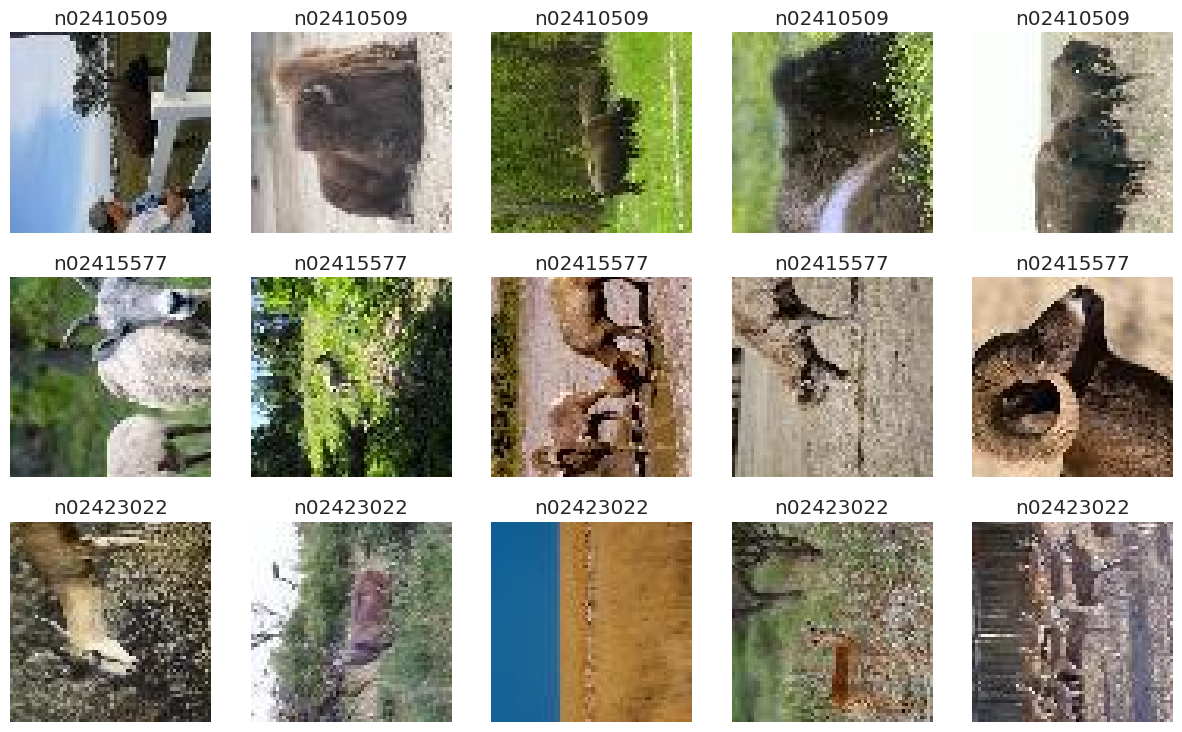

In [93]:
visualize(nb_shots, nb_ways, query_set)

# Exercise 2

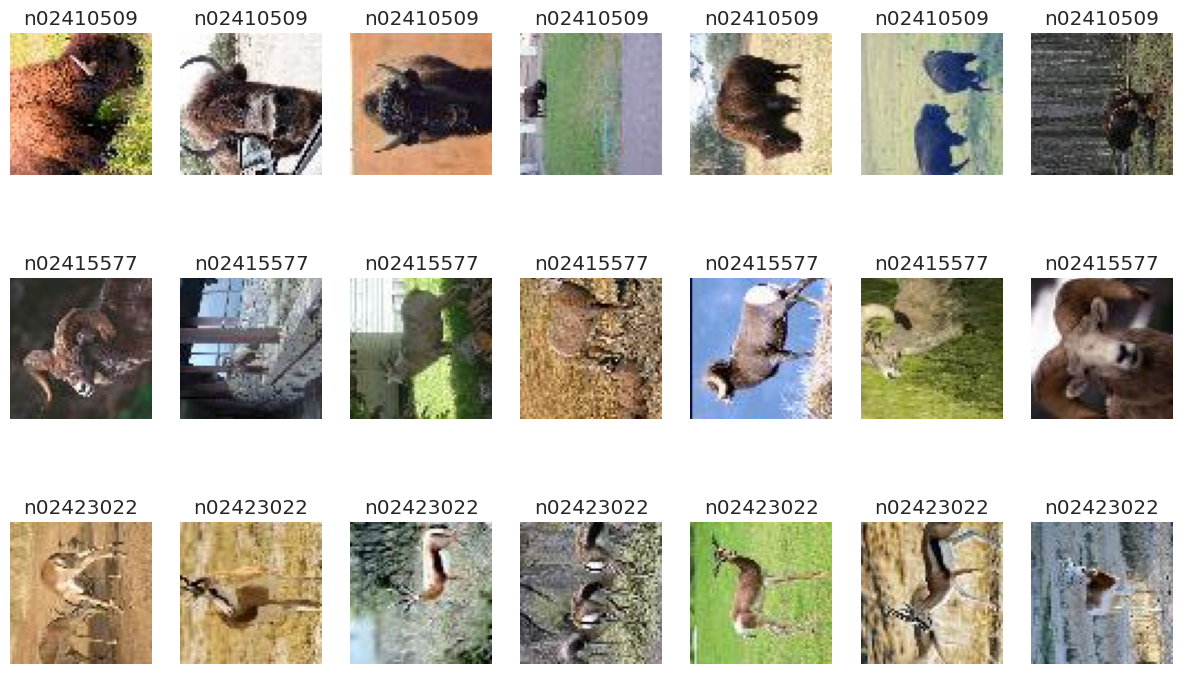

In [94]:
nb_shots = 7
support_test, selected_indices = support(nb_shots, dataset, selected_classes)
query_test = query(nb_shots, dataset, selected_classes, selected_indices)
visualize(nb_shots, nb_ways, query_test)

In [95]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Training the model TinyNet40

In [96]:
import torch.optim as optim

# Créer un modèle ConvNet
class TinyNet40(nn.Module):
    def __init__(self, in_channels=3):
        super(TinyNet40, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*4*4, 1000)  # Nombre de neurones dans la 1ère couche dense
        self.fc2 = nn.Linear(1000, 40)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        #print(x.shape)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model40 = TinyNet40().to(device)
print(model40)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model40.parameters(), lr=0.01)

TinyNet40(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=40, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.25, inplace=False)
)


# Pipeline preparation for the TinyNet40

In [97]:
from torch.utils.data import DataLoader, Dataset
import os

class TinyImageNetLoader(Dataset):
    def __init__(self, root_dir, split='train', transform=None, num_classes=20):
        self.root_dir = root_dir
        self.transform = transform
        self.num_classes = num_classes
        self.split = split

        # Create a list of all image file paths and their corresponding labels
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Determine the subdirectory based on the split ('train' or 'val')
        if split == 'train' or split == 'test':
            data_dir = 'train'
            label_file = 'wnids.txt'
        elif split == 'val':
            data_dir = 'val/images'
            label_file = 'val_annotations.txt'
        else:
            raise ValueError("Invalid 'split' value. Use 'train', 'val' or 'test'.")

        # Load class names and labels from the 'wnids.txt' file
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            class_names = f.read().splitlines()[:num_classes]

        for i, class_name in enumerate(class_names):
            self.class_to_idx[class_name] = i

        # Load image file paths and labels for each class
        if split == 'train':
            for class_name, class_idx in self.class_to_idx.items():
                class_dir = os.path.join(root_dir, data_dir, class_name, 'images')
                image_files = os.listdir(class_dir)
                index = 0
                for image_file in image_files:
                    #we keep the firsts 450 images for train
                    if index == 450:
                        break
                    image_path = os.path.join(class_dir, image_file)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)
                    index+=1
        elif split == 'test':
            for class_name, class_idx in self.class_to_idx.items():
                class_dir = os.path.join(root_dir, data_dir, class_name, 'images')
                image_files = os.listdir(class_dir)
                index = 0
                for image_file in image_files:
                    #we keep the last 50 images for test
                    if index < 450:
                        index+=1
                        continue
                    image_path = os.path.join(class_dir, image_file)
                    self.image_paths.append(image_path)
                    self.labels.append(class_idx)
        elif split == 'val':
            with open(os.path.join(root_dir, 'val', 'val_annotations.txt'), 'r') as f:
                lines = f.read().splitlines()
                for line in lines:
                    parts = line.split('\t')
                    image_path = os.path.join(root_dir, data_dir, parts[0])
                    class_name = parts[1]
                    if class_name in class_names:
                        class_idx = self.class_to_idx[class_name]
                        self.image_paths.append(image_path)
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)  # Convert label to tensor

        return image, label

# Example usage:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Convert the image to a tensor
])

# Specify the number of classes you want (e.g., 20)
num_classes = 40
batch_size = nb_shots*nb_ways

In [98]:
def val(model, data_val, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_accuracy = 0.0
    num_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_val):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total_accuracy += correct
            num_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    average_test_loss = total_loss / len(data_val)
    accuracy = (total_accuracy / num_samples) * 100

    #print(f'Average Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return all_labels, all_predictions, average_test_loss, accuracy

In [99]:
def test(model, data_test, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_test:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(data_test.dataset)
    accuracy = 100 * correct / len(data_test.dataset)

    return test_loss, accuracy, all_labels, all_preds

In [100]:
def plot_history(epochs, train_losses, train_accuracies, val_losses, val_accuracies):
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(all_labels, all_predictions):
    confusion = confusion_matrix(all_labels, all_predictions)
    # Create a heatmap of the confusion matrix with seaborn
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)  # Adjust font size as needed
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)

    # Customize the plot (labels, title, etc.)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [102]:
def pipeline(epochs, model, data_train, data_val, data_test, optimizer, criterion, device, stats=True):
    
    #return the best_model according to the best val_accuracy
    best_model = model.state_dict()
    best_val_accuracy = 0
    
    all_labels, all_preds = None, None

    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(data_train):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        average_loss = running_loss / len(data_train)
        training_losses.append(average_loss)

        accuracy = 100 * correct / total
        training_accuracies.append(accuracy)
        
        all_labels, all_preds, val_loss, val_accuracy = val(model, data_val, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()
            
        print(f'Epoch [{epoch + 1}/{epochs}], train_loss: {average_loss:.2f}, train_accuracy: {accuracy:.2f}%, val_loss: {val_loss:.2f}, val_accuracy: {val_accuracy:.2f}%')

    print('Training complete')
    
    #we keep the best model
    model.load_state_dict(best_model)
    
    if stats:
        
        plot_history(epochs, training_losses, training_accuracies, val_losses, val_accuracies)

        test_loss, test_accuracy, all_labels, all_preds = test(model, data_test, criterion, device)
        print(f'Test loss: {test_loss:.2f}, Test accuracy: {test_accuracy:.2f}%')

        conf_matrix(all_labels, all_preds)
    
    return model

Epoch [1/2], train_loss: 2.96, train_accuracy: 20.62%, val_loss: 2.65, val_accuracy: 28.20%
Epoch [2/2], train_loss: 2.40, train_accuracy: 34.21%, val_loss: 2.18, val_accuracy: 39.65%
Training complete


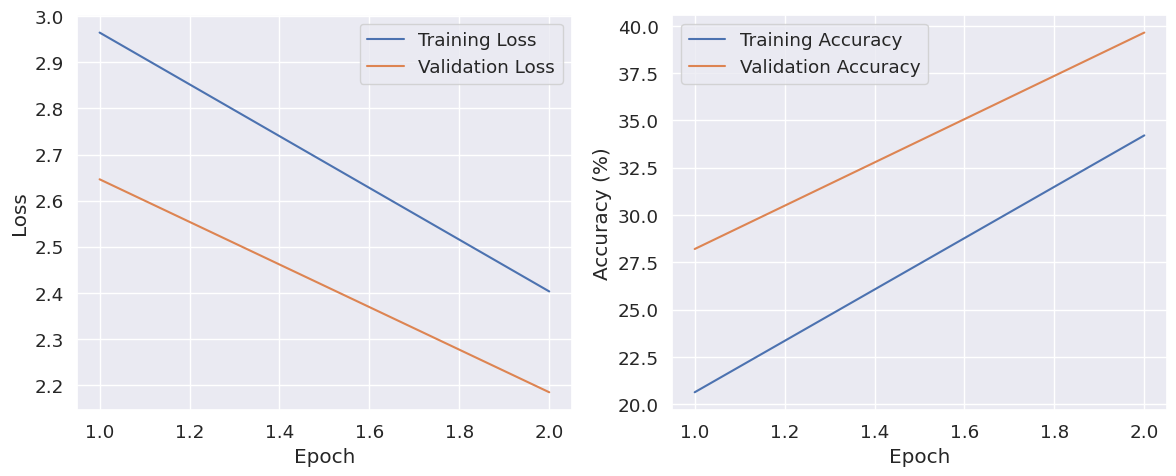

Test loss: 0.31, Test accuracy: 40.20%


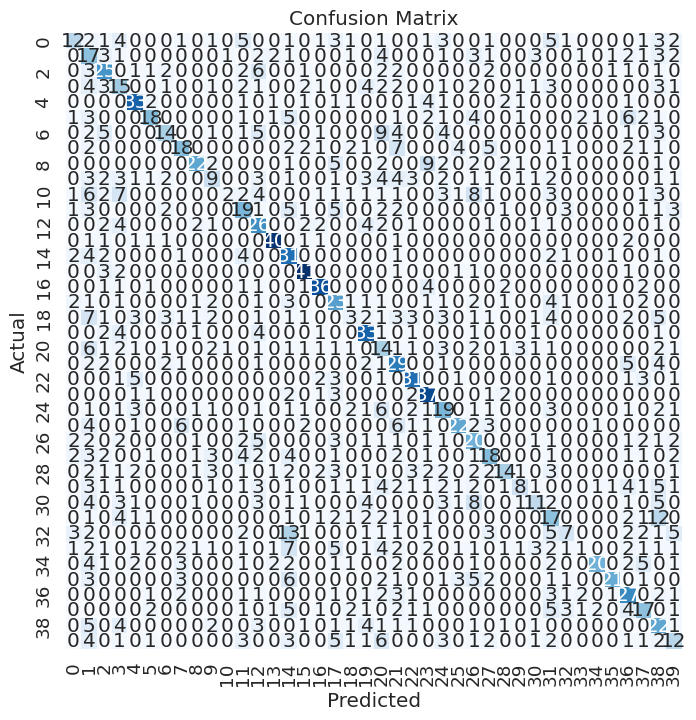

In [103]:
from PIL import Image
epochs = 2
best_model = pipeline(epochs, model40, data_train_40, data_val_40, data_test_40, optimizer, criterion, device)

In [104]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data_list, classes):
        self.data_list = data_list
        self.classes = classes
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        img, label = self.data_list[index]
        img = self.transform(img)
        label = self.classes.index(label)
        label = torch.tensor(label)
        
        return img, label

support_dataset = CustomDataset(support_test, selected_classes)
query_dataset = CustomDataset(query_test, selected_classes)

support_loader = DataLoader(support_dataset, batch_size=len(support_test), shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=len(query_test), shuffle=False)

support_images, support_labels = next(iter(support_loader))
query_images, query_labels = next(iter(query_loader))

In [105]:
import torch.nn as nn
import torch

class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        support_labels = support_labels.to(device)

        
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(nb_ways)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        scores = -dists
        return scores


prototypical_model = PrototypicalNetworks(model40)

scores = prototypical_model(support_images, support_labels, query_images)

print(scores)


tensor([[ -8.0388,  -6.8860,  -9.1778],
        [-10.1051, -11.1923,  -8.5020],
        [-15.2195, -18.0261, -14.4856],
        [ -9.5077, -10.1382,  -8.1850],
        [-12.8211, -14.8993, -14.0323],
        [ -8.0903,  -8.3550,  -7.0181],
        [ -8.3602,  -7.2225,  -8.8969],
        [ -6.3917,  -6.8594,  -3.9286],
        [ -9.9056, -11.3068,  -7.5451],
        [ -7.4209,  -7.0998,  -8.2060],
        [ -8.1875,  -7.2387,  -9.4550],
        [ -8.3999,  -9.4779,  -7.4320],
        [-10.1387, -10.6999, -10.3671],
        [ -8.8741, -12.3148,  -8.9175],
        [-12.3146, -12.4112, -10.1243],
        [ -8.6257, -10.3906,  -8.4485],
        [ -7.6390,  -5.3455,  -8.1042],
        [-10.5296,  -9.0701,  -8.4362],
        [-14.2241, -14.2618, -14.4853],
        [ -9.0825,  -9.2085,  -8.6244],
        [ -6.9692,  -7.0625,  -6.8138]], device='cuda:0',
       grad_fn=<NegBackward0>)


In [106]:
probs = torch.nn.functional.softmax(scores, dim=-1)
predicted_labels = torch.argmax(scores, dim=-1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(support_labels.cpu(), predicted_labels.cpu())

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.3810


we obtain almost the same accuracy than the TinyNet40 with only the 5 support images

# exercise 3

# 5-ways 5-shots

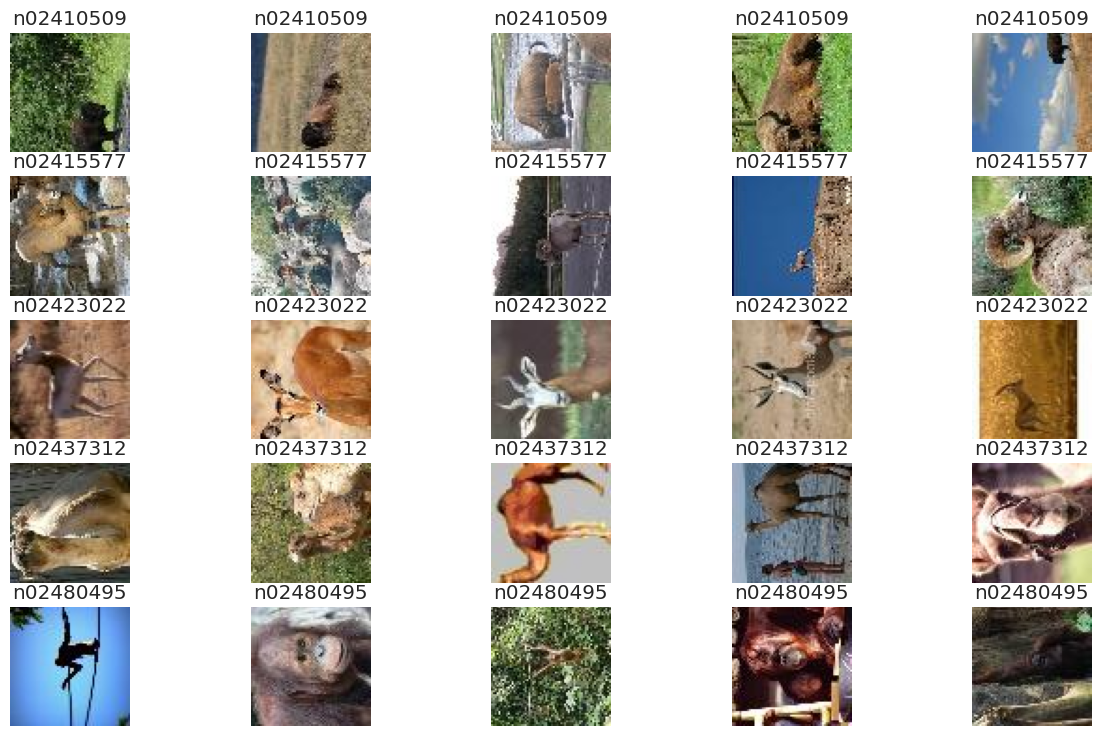

In [112]:
nb_shots = 5
nb_ways = 5
selected_classes = class_names[50:50+nb_ways]
support_test, selected_indices = support(nb_shots, dataset, selected_classes)
query_test = query(nb_shots, dataset, selected_classes, selected_indices)
visualize(nb_shots, nb_ways, query_test)

In [113]:
prototypical_model_5x5 = PrototypicalNetworks(model40)

support_dataset = CustomDataset(support_test, selected_classes)
query_dataset = CustomDataset(query_test, selected_classes)


support_loader = DataLoader(support_dataset, batch_size=len(support_test), shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=len(query_test), shuffle=False)

support_images, support_labels = next(iter(support_loader))
query_images, query_labels = next(iter(query_loader))

scores_5x5 = prototypical_model(support_images, support_labels, query_images)

In [114]:
probs = torch.nn.functional.softmax(scores_5x5, dim=-1)
predicted_labels = torch.argmax(scores_5x5, dim=-1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_5x5 = accuracy_score(support_labels.cpu(), predicted_labels.cpu())

print(f"Accuracy: {accuracy_5x5:.4f}")

Accuracy: 0.3200


# 8-ways 5-shots

In [116]:
nb_shots = 5
nb_ways = 8
selected_classes = class_names[50:50+nb_ways]
support_test, selected_indices = support(nb_shots, dataset, selected_classes)
query_test = query(nb_shots, dataset, selected_classes, selected_indices)

In [117]:
prototypical_model_8x5 = PrototypicalNetworks(model40)

support_dataset = CustomDataset(support_test, selected_classes)
query_dataset = CustomDataset(query_test, selected_classes)


support_loader = DataLoader(support_dataset, batch_size=len(support_test), shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=len(query_test), shuffle=False)

support_images, support_labels = next(iter(support_loader))
query_images, query_labels = next(iter(query_loader))

scores_8x5 = prototypical_model(support_images, support_labels, query_images)

In [118]:
probs = torch.nn.functional.softmax(scores_8x5, dim=-1)
predicted_labels = torch.argmax(scores_8x5, dim=-1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_8x5 = accuracy_score(support_labels.cpu(), predicted_labels.cpu())

print(f"Accuracy: {accuracy_8x5:.4f}")

Accuracy: 0.3000


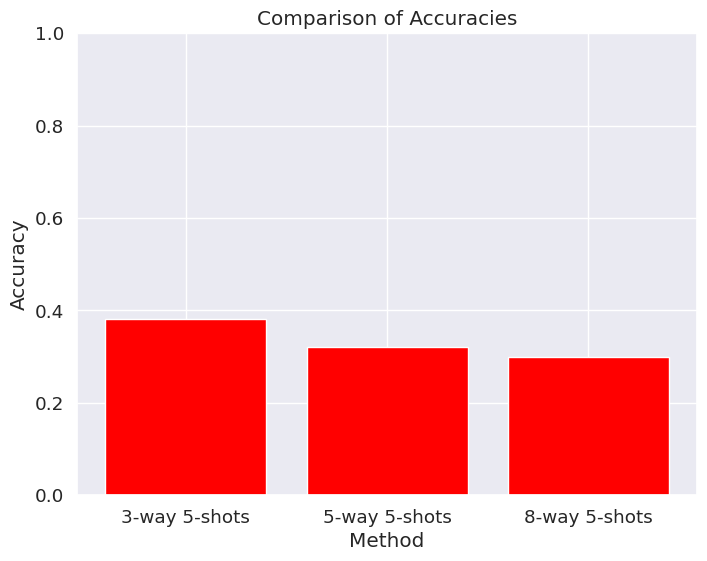

In [123]:
import pandas as pd

accuracies = {
    '3-way 5-shots': accuracy,
    '5-way 5-shots': accuracy_5x5,
    '8-way 5-shots': accuracy_8x5,
}

# Convert to pandas DataFrame
df = pd.DataFrame(list(accuracies.items()), columns=['Method', 'Accuracy'])

# Create a bar chart using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(df['Method'], df['Accuracy'], color=['red' if acc <= 0.9 else 'green' for acc in df['Accuracy']])
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies')
plt.ylim(0, 1) 

plt.show()

# exercise 4

# 5-way 10-shots

In [124]:
nb_shots = 10
nb_ways = 5
selected_classes = class_names[50:50+nb_ways]
support_test, selected_indices = support(nb_shots, dataset, selected_classes)
query_test = query(nb_shots, dataset, selected_classes, selected_indices)

prototypical_model_5x10 = PrototypicalNetworks(model40)

support_dataset = CustomDataset(support_test, selected_classes)
query_dataset = CustomDataset(query_test, selected_classes)


support_loader = DataLoader(support_dataset, batch_size=len(support_test), shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=len(query_test), shuffle=False)

support_images, support_labels = next(iter(support_loader))
query_images, query_labels = next(iter(query_loader))

scores_5x10 = prototypical_model(support_images, support_labels, query_images)

probs = torch.nn.functional.softmax(scores_5x10, dim=-1)
predicted_labels = torch.argmax(scores_5x10, dim=-1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_5x10 = accuracy_score(support_labels.cpu(), predicted_labels.cpu())

print(f"Accuracy: {accuracy_5x10:.4f}")

Accuracy: 0.3400


# 5-way 20-shots

In [125]:
nb_shots = 20
nb_ways = 5
selected_classes = class_names[50:50+nb_ways]
support_test, selected_indices = support(nb_shots, dataset, selected_classes)
query_test = query(nb_shots, dataset, selected_classes, selected_indices)

prototypical_model_5x20 = PrototypicalNetworks(model40)

support_dataset = CustomDataset(support_test, selected_classes)
query_dataset = CustomDataset(query_test, selected_classes)


support_loader = DataLoader(support_dataset, batch_size=len(support_test), shuffle=False)
query_loader = DataLoader(query_dataset, batch_size=len(query_test), shuffle=False)

support_images, support_labels = next(iter(support_loader))
query_images, query_labels = next(iter(query_loader))

scores_5x20 = prototypical_model(support_images, support_labels, query_images)

probs = torch.nn.functional.softmax(scores_5x20, dim=-1)
predicted_labels = torch.argmax(scores_5x20, dim=-1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_5x20 = accuracy_score(support_labels.cpu(), predicted_labels.cpu())

print(f"Accuracy: {accuracy_5x20:.4f}")

Accuracy: 0.3900


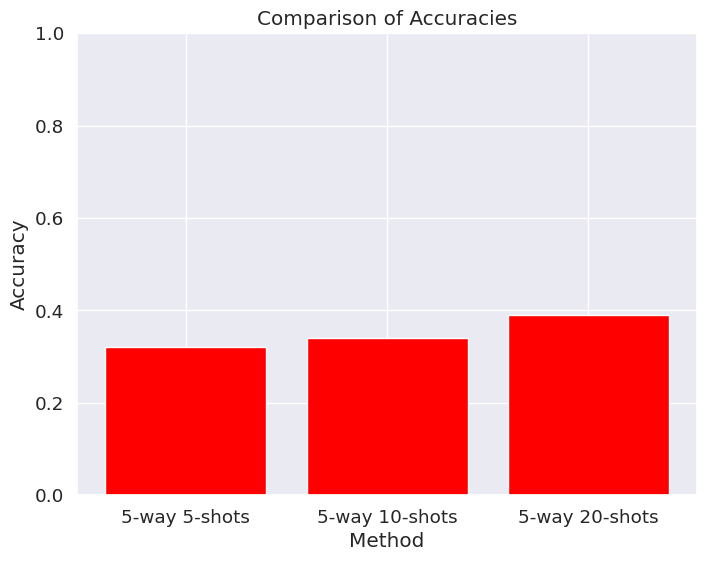

In [131]:
accuracies = {
    '5-way 5-shots': accuracy_5x5,
    '5-way 10-shots': accuracy_5x10,
    '5-way 20-shots': accuracy_5x20,
}

# Convert to pandas DataFrame
df = pd.DataFrame(list(accuracies.items()), columns=['Method', 'Accuracy'])

# Create a bar chart using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(df['Method'], df['Accuracy'], color=['red' if acc <= 0.9 else 'green' for acc in df['Accuracy']])
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies')
plt.ylim(0, 1)

plt.show()

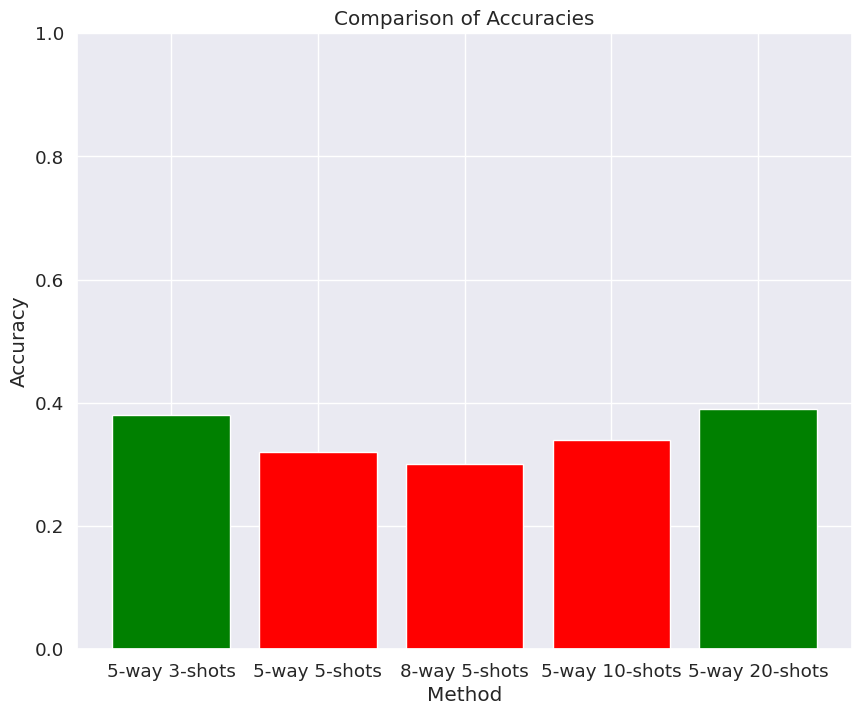

In [137]:
accuracies = {
    '5-way 3-shots': accuracy,
    '5-way 5-shots': accuracy_5x5,
    '8-way 5-shots': accuracy_8x5,
    '5-way 10-shots': accuracy_5x10,
    '5-way 20-shots': accuracy_5x20,
}

# Convert to pandas DataFrame
df = pd.DataFrame(list(accuracies.items()), columns=['Method', 'Accuracy'])

# Create a bar chart using Matplotlib
plt.figure(figsize=(10, 8))
plt.bar(df['Method'], df['Accuracy'], color=['red' if acc <= 0.35 else 'green' for acc in df['Accuracy']])
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies')
plt.ylim(0, 1)

plt.show()